In [20]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path
import pickle
from tqdm import tqdm

import warnings; warnings.simplefilter('ignore')

<img src="dataset-cover.png" alt="Goodreads dataset" />

Проект по анализу данных с сервиса Goodreads. \
Goodreads это сайт с каталогом книг, где люди могут оставлять свои оценки, делиться прочитанными книгами, составлять свои подборки и следить за подборками и обзорами на книги других пользователей. 

Данный проект состоит из трёх этапов:
* Классическая аналитика данных, использование tf-idf для анализа описаний к книгам. (этот ноутбук)
* Построение эмбедингов на основе текстовой информации из описания к книге. Для этого будут использоваться трансформеры для задачи Text Similarity.
* Телеграм-бот с функцией подбора похожий авторов / похожих книг.

#### Описание полей датасета:
* <b>Name</b> - название книги
* <b>RatingDist*</b> - кол-во оценок книги с рейтингом 1/2/3/4/5
* <b>Rating</b> - средний рейтинг
* <b>pagesNumber</b> - кол-во страниц в книге
* <b>Publisher</b> - издательство
* <b>Authors</b> - автор / авторы
* <b>Language</b> - язык написания книги
* <b>Description</b> - краткое описание

In [4]:
full_dataset = pd.concat([pd.read_csv(str(x.resolve())) for x in Path("data/").glob("*k.csv")])

columns = ['Id', 'Name', 'RatingDist1', 'RatingDist2', 'RatingDist3',
           'RatingDist4', 'RatingDist5', 'Rating', 'RatingDistTotal', 'pagesNumber', 'Publisher',
           'Authors', 'Language', 'Description']
full_dataset = full_dataset[columns]
full_dataset = full_dataset[~full_dataset['Description'].isna()]

full_dataset['RatingDistTotal'] = full_dataset['RatingDistTotal'].apply(lambda x: float(x.replace('total:', '')))

In [5]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

full_dataset = reduce_mem_usage(full_dataset)

Mem. usage decreased to 113.93 Mb (15.0% reduction)


##### Проведем аналитику по данным, посчитаем основные статистики.

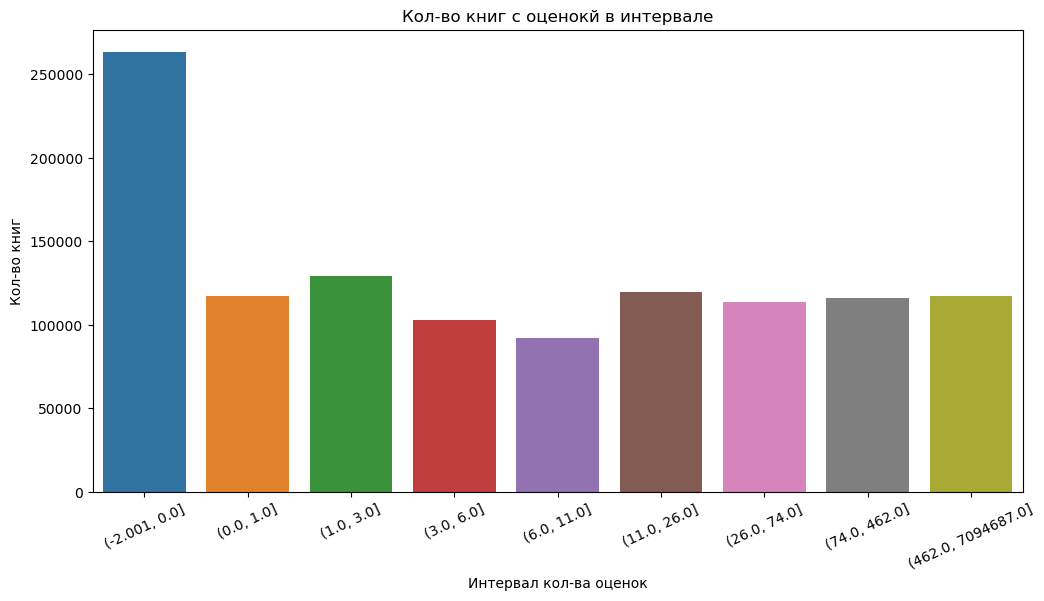

In [7]:
# Распределение кол-ва оценок

tmp = pd.qcut(full_dataset['RatingDistTotal'], 10, duplicates='drop').value_counts().sort_index()

plt.figure(figsize=(12, 6))
sns.barplot(x=tmp.index, y=tmp.values)
plt.xticks(rotation=25)

plt.title('Кол-во книг с оценокй в интервале')
plt.xlabel('Интервал кол-ва оценок')
plt.ylabel('Кол-во книг')
plt.show()

<AxesSubplot:xlabel='Rating', ylabel='Count'>

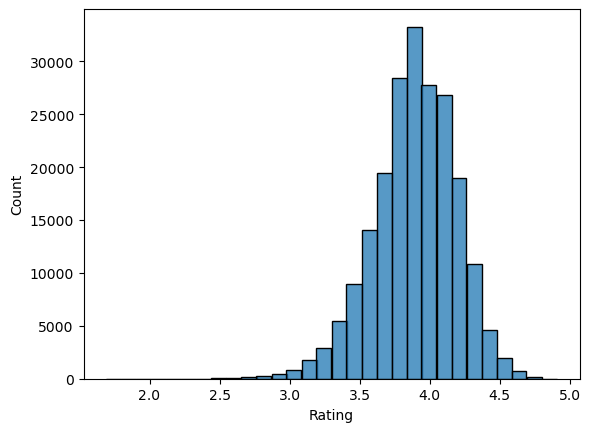

In [8]:
# Распределение рейтинга для книг у которых больше 100 оценок.

tmp = full_dataset[full_dataset['RatingDistTotal'] >= 100]

sns.histplot(tmp['Rating'], bins=30)

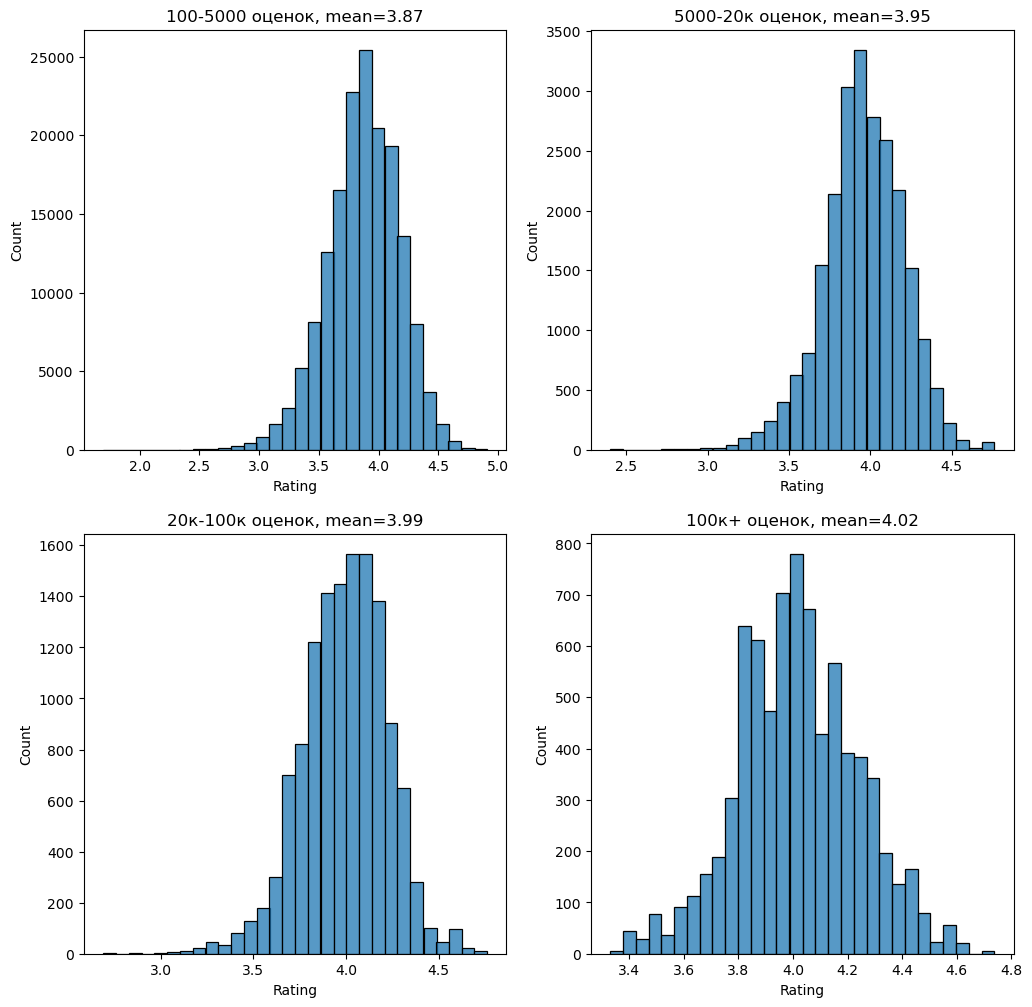

In [9]:
# Распределение рейтинга в зависимости от популярности.

tmp1 = full_dataset[(full_dataset['RatingDistTotal'] >= 100) & (full_dataset['RatingDistTotal'] < 5000)]
tmp2 = full_dataset[(full_dataset['RatingDistTotal'] >= 5000) & (full_dataset['RatingDistTotal'] < 20000)]
tmp3 = full_dataset[(full_dataset['RatingDistTotal'] >= 20000) & (full_dataset['RatingDistTotal'] < 100000)]
tmp4 = full_dataset[(full_dataset['RatingDistTotal'] >= 100000)]


fig, axs = plt.subplots(ncols=2, nrows=2,  figsize=(12, 12))

sns.histplot(tmp1['Rating'], bins=30, ax=axs[0][0])
sns.histplot(tmp2['Rating'], bins=30, ax=axs[0][1])
sns.histplot(tmp3['Rating'], bins=30, ax=axs[1][0])
sns.histplot(tmp4['Rating'], bins=30, ax=axs[1][1])

tmp_datasets = [tmp1, tmp2, tmp3, tmp4]
mean_vals = [str(round(tmp['Rating'].values.mean(), 2)) for tmp in tmp_datasets]

axs[0][0].title.set_text(f"100-5000 оценок, mean={mean_vals[0]}")
axs[0][1].title.set_text(f"5000-20к оценок, mean={mean_vals[1]}")
axs[1][0].title.set_text(f"20к-100к оценок, mean={mean_vals[2]}")
axs[1][1].title.set_text(f"100к+ оценок, mean={mean_vals[3]}")

plt.show()

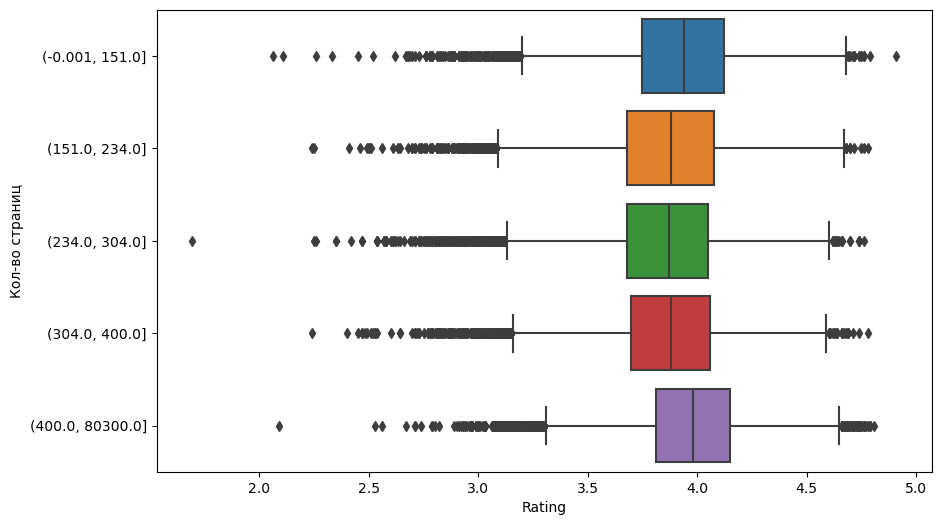

In [10]:
# Распределение оценок в зависимости от кол-ва страниц

tmp = full_dataset[full_dataset['RatingDistTotal'] >= 100]
tmp['pagesNum_interval'] = pd.qcut(tmp['pagesNumber'], 5)

plt.figure(figsize=(10, 6))
sns.boxplot(x=tmp['Rating'], y=tmp['pagesNum_interval'])
plt.ylabel('Кол-во страниц')
plt.show()

In [11]:
# Одним из самых популярных и хорошо оцениваемых произведений.

tmp = full_dataset[(full_dataset['RatingDistTotal'] > 20000) & (full_dataset['Rating'] >= 4.6)][['Name', 'Authors', 'Rating', 'RatingDistTotal']]
tmp2 = pd.DataFrame(tmp.groupby('Authors')['RatingDistTotal'].max()).reset_index()

pd.merge(tmp, tmp2, on=['Authors', 'RatingDistTotal']).drop_duplicates()

,Name,Authors,Rating,RatingDistTotal
0,Calvin and Hobbes,Bill Watterson,4.601562,138507.0
1,Jesus the Christ,James E. Talmage,4.621094,21366.0
2,"An Echo in the Darkness (Mark of the Lion, #2)",Francine Rivers,4.621094,41556.0
3,Niv Compact Thinline Bible,Anonymous,4.601562,62482.0
4,Selections from Harry Potter and the Order of ...,John Williams,4.710938,26562.0
5,Harry Potter e as Relíquias da Morte (Harry Po...,J.K. Rowling,4.621094,2824905.0
6,NARUTO -ナルト- 巻ノ四十三,Masashi Kishimoto,4.601562,37880.0
7,The Hobbit and The Lord of the Rings,J.R.R. Tolkien,4.601562,107724.0


Попробуе составить для каждой книги набор ключевых слов. Для этого воспользуемся TF-IDF.

In [17]:
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer

from sklearn.feature_extraction.text import TfidfVectorizer

import string
import re

In [13]:
PUNCT_TO_REMOVE = string.punctuation
STOPWORDS = set(stopwords.words('english'))


def text_preprocessing_step1(text):
    text = text.lower()

    # Удаляем html-теги
    re_html = re.compile(r'<.*?>')
    text = re_html.sub(' ', text)

    # Удаляем пунктуацию
    text = text.translate(str.maketrans('', '', PUNCT_TO_REMOVE))

    # Удаляем стоп-слова
    text = " ".join([word.strip() for word in str(text).split() if word not in STOPWORDS])

    return text.strip()

descriptions = full_dataset['Description'].apply(text_preprocessing_step1)

In [ ]:
# Stemming
stemmer = PorterStemmer()

def stem_words(text):
    return " ".join([stemmer.stem(word) for word in text.split()])

descriptions = descriptions.apply(stem_words)

In [ ]:
lemmatizer = WordNetLemmatizer()
def lemmatize_words(text):
    return " ".join([lemmatizer.lemmatize(word) for word in text.split()])

descriptions = descriptions.apply(lemmatize_words)

In [16]:
# Можно загрузить уже предобработанные заранее данные.
with open('data/preprocessed_descriptions_v1.pkl', 'rb') as file:
    descriptions = pickle.load(file)

In [18]:
vectorizer = TfidfVectorizer()

X = vectorizer.fit_transform(descriptions)
inverse_vocab = {idx: word for word, idx in vectorizer.vocabulary_.items()}

In [21]:
# Отфильтруем часть книг, оставив только те, у которых высокий рейтинг

filters = (full_dataset['RatingDistTotal'] > 20000) & (full_dataset['Rating'] >= 4.)
data_top = full_dataset[filters][['Name', 'Authors', 'Rating', 'RatingDistTotal', 'Description']]
X_top = X[filters]

In [22]:
# Посчитаем top-10 слов по tf-idf для каждого описания
top_words = []

for idx in tqdm(range(X_top.shape[0])):
    word_idxs = np.argsort(X_top[idx].toarray()[0])[::-1][:10]
    local_words = [inverse_vocab[idx] for idx in word_idxs]

    top_words.append(local_words)

data_top['top_words'] = top_words

100%|██████████| 10623/10623 [05:08<00:00, 34.46it/s]


Посмотрим полученные ключевые слова отдтельных авторов/книг

In [23]:
# Stephen King, It
data_top[data_top['Name'] == 'It']['top_words'].iloc[4]

['derri',
 'without',
 'hauntingli',
 'withstand',
 'grownup',
 'hometown',
 'stumbl',
 'none',
 'nightmar',
 'horror']

In [24]:
# Stephen King, The Green Mile
data_top[data_top['Name'] == 'The Green Mile']['top_words'].iloc[0]

['edgecomb',
 'coffey',
 'mile',
 'depressionworn',
 'simultaneously',
 'lists',
 'green',
 'cold',
 'mountain',
 'sparki']

In [25]:
# J.K. Rowling, Harry Potter and the Prisoner of Azkaban
data_top[data_top['Name'].str.contains('Harry Potter and the Prisoner of Azkaban')]['top_words'].iloc[3]

['siriu',
 'hogwart',
 'dementor',
 'harri',
 'azkaban',
 'wizard',
 'scholasticcom',
 'quidditch',
 'fourthyear',
 'topofthelin']

In [26]:
# Agatha Christie, Crooked House
data_top[data_top['Name'] == 'Crooked House']['top_words'].iloc[0]

['leonid',
 'hayward',
 'ramshackl',
 'astrid',
 'granddaught',
 'sprawl',
 'millionair',
 'mansion',
 'household',
 'charl']

In [27]:
# Arthur Conan Doyle, The Adventures of Sherlock Holmes
data_top[data_top['Name'] == 'The Adventures of Sherlock Holmes']['top_words'].iloc[0]

['holm',
 'londonbas',
 'pip',
 'bohemia',
 'bearer',
 'redhead',
 'prowess',
 'thumb',
 'deduct',
 'sherlock']